# SCC0270 - Redes Neurais e Aprendizado Profundo

## Trabalho Prático 2 - Previsão do valor de ações utilizando LSTM

NOME: Felipe Andrade Garcia Tommaselli 

NUSP: 11800910

---


NOME: Diego Fleury Corrêa De Moraes

NUSP: 11800584

Neste trabalho os alunos deverão implementar redes neurais recorrentes do tipo LSTM para tarefa de previsão do valor de ações. Utilizaremos um histórico de ações da empresa Apple negociada na Bolsa de Valores americana NASDAQ, disponibilizada em um arquivo txt.

Será fornecida toda a etapa de prepação dos dados. Os objetivos dos alunos são:
1. Complementar as lacunas deste notebook com códigos próprios a fim de se criar um modelo preditivo básico. Este modelo deverá ser treinado no conjunto de treino e sua performance deverá ser avaliada no conjunto de teste utilizando a métrica RSME.
2. Adaptar o modelo básico com quaisquer técnicas que façam parte do escopo da disciplina visto até aqui (módulos 1 a 8) com intuito de reduzir o RSME obtido com o modelo básico. Você também pode alterar quaisquer parâmetros da rede, inclusive sua arquitetura e a função de perda e o algoritmo de otimização utilizados no treinamento.

Referência sobre como melhorar a performance de redes neurais: https://arxiv.org/abs/2109.02752

Ao implentar com sucesso o modelo básico você deverá ter um resultado semelhante ao da imagem abaixo, com RMSE de 53.39 obtido no conjunto de teste. Vamos denominar esse RMSE como __BASE__.

__RMSE BASE__ = 53.39

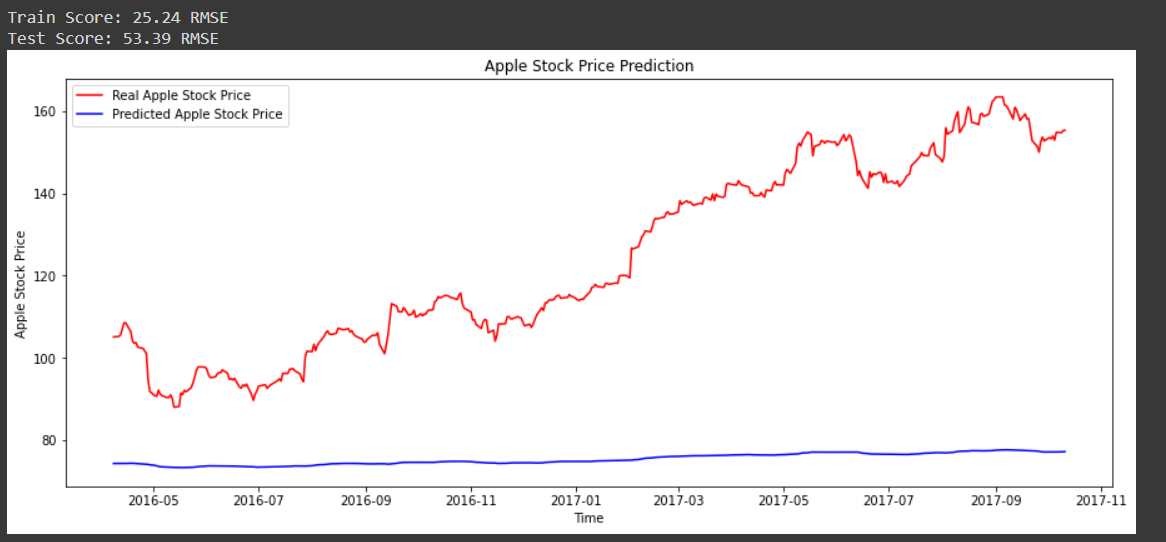

Alguns ajustes no modelo podem prozudir resultados bem melhores, como o exibido abaixo. Este modelo ajustado produziu RMSE de 3.83 no conjunto de teste. Vamos chamar esse RMSE de __REFERÊNCIA__.

__RMSE REFERÊNCIA__: 3.83

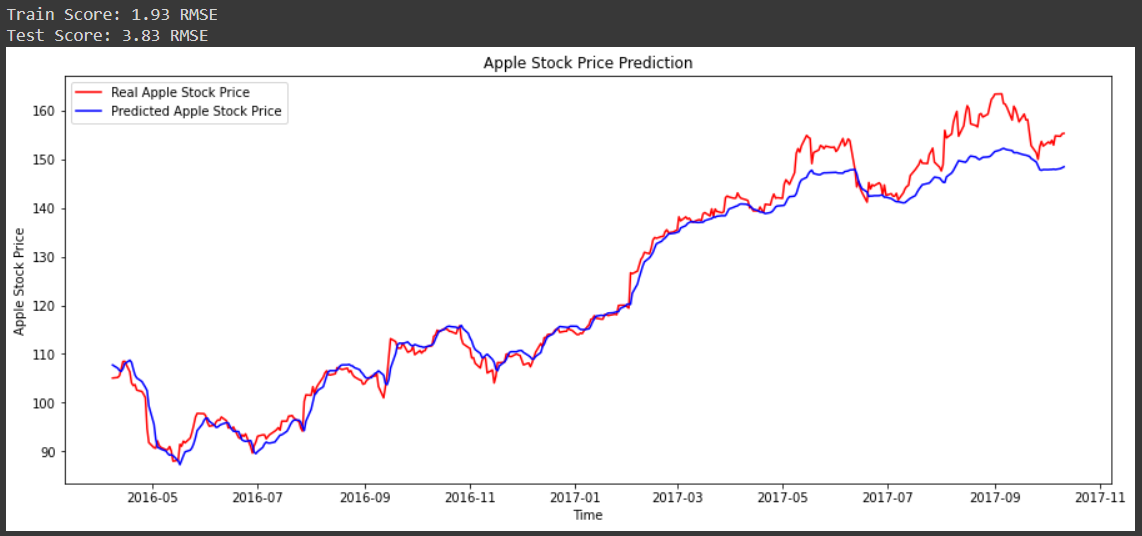

## Avaliação

A avaliação deste trabalho consiste em três critérios:
1. Implementação do modelo base: **3 pontos**;
2. Qualidade do código implementado em todo o notebook (estrutura, comentários, legibilidade e justificativas das escolhas realizadas): **3 pontos**;
3. Melhora apresentada no RMSE obtido com seu modelo adaptado (objetivo 2) medido no conjunto de dados de teste em comparação com o __RMSE BASE__. Essa melhora será medida em termos percentuais, sendo que o __RMSE REFERÊNCIA__ representa 100%: **4 pontos**;

### Apuração da nota do critério 3:

```
NOTA = (1 - (RMSE REFERÊNCIA - RMSE aluno)/(RMSE REFERÊNCIA - RMSE BASE)) * 4
```


*   Se RMSE aluno < RMSE BASE -> NOTA = 0
*   SE RMSE aluno > RMSE REFERÊNCIA -> NOTA = 4



Ex.1: Se o RMSE do seu modelo foi de 45.0, então sua nota neste critério será: 0.67

Ex.2: Se o RSME do seu modelo foi de 4.50, então sua nota neste critério será: 3.95

## Setup

Essa primeira célula não precisa ser executada se você não estiver trabalhando com o Colab.

In [42]:
# mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [43]:
# imports

# pacotes padrão para manipulação, operações e visualização de dados 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math

# pacotes para estruturação das redes
import torch
import torch.nn as nn

# pacotes complementares
from sklearn.preprocessing import MinMaxScaler  # normalização dos dados
from sklearn.metrics import mean_squared_error  # cálculo do erro quadrático médio

## Preparação dos dados

Rode todas as células a seguir executando os ajustes necessários

In [44]:
# Ajuste essa parte do código para fazer a leitura do arquivo txt fornecido de forma adequada ao IDE que está utilizando

path = './' # seu caminho aqui
aapl_file = 'aapl.us.txt'

df_aapl = pd.read_csv(path+aapl_file, index_col='Date', parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])

In [45]:
print(df_aapl.shape)
df_aapl.head(5)

(8364, 1)


,Close
Date,
1984-09-07,0.42388
1984-09-10,0.42134
1984-09-11,0.42902
1984-09-12,0.41618
1984-09-13,0.43927


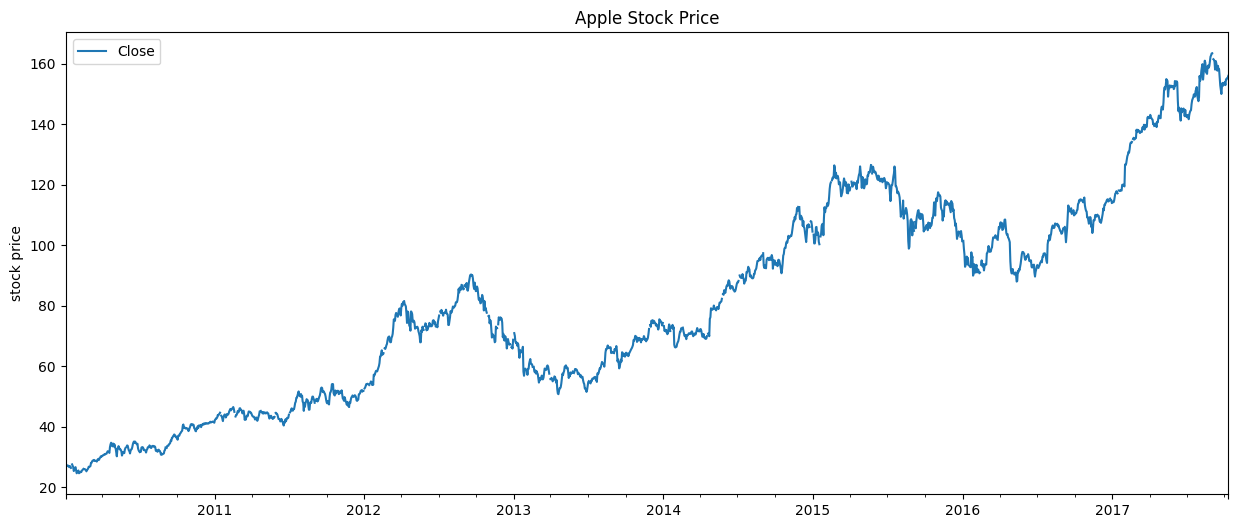

In [46]:
# esse será o range de datas que iremos utilizar
dates = pd.date_range('2010-01-02','2017-10-11', freq='B')
df = pd.DataFrame(index=dates)
df_aapl = df.join(df_aapl)

# visualização
df_aapl[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock price")
plt.title("Apple Stock Price")
plt.show()

In [47]:
df_aapl=df_aapl[['Close']]
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 96.2 KB


In [48]:
# vamos normalizar/escalar os dados
scaler = MinMaxScaler(feature_range=(-1, 1))

df_aapl=df_aapl.fillna(method='ffill') # ffill: propaga a última observação válida
df_aapl['Close'] = scaler.fit_transform(df_aapl['Close'].values.reshape(-1,1))
print(df_aapl.shape)

(2028, 1)


In [49]:
def load_data(df, look_back, test_size):
  '''
  Função que cria os conjuntos de treino e teste e define o comprimento da sequência de análise.
  O comprimento da sequência é o período de tempo (em dias) da previsão.
  Parâmetros:
    df: Pandas DataFrame
    look_back: comprimento da sequência (horizonte de previsão)
    test_size: percentual do conjunto de dados total destinado ao conjunto de teste (0 < test_size < 1).
  '''

  data_raw = df.values    # extrai os valores somente
  data = []               # lista para acrescentar dados

  # cria todas as sequências possíveis de comprimento (horizonte de previsão)
  for index in range(len(data_raw) - look_back): 
      data.append(data_raw[index: index + look_back])

  data = np.array(data);  # converte para numpy array
  
  # criação dos conjuntos de teste e treino
  test_set_size = int(np.round(test_size*data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);

  x_train = data[:train_set_size,:-1,:] # define um comprimento de 59 preços de ações
  y_train = data[:train_set_size,-1,:]  # e o 60º é a varível resposta

  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]

  # converte para pytorch tensors
  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train = torch.from_numpy(y_train).type(torch.Tensor)
  y_test = torch.from_numpy(y_test).type(torch.Tensor)

  return [x_train, y_train, x_test, y_test]

In [50]:
look_back = 60 # horizonte de previsão
x_train, y_train, x_test, y_test = load_data(df_aapl, look_back, 0.2)

In [51]:
print(y_train.size())
print(x_train.size())
print(y_test.size())
print(x_test.size())

torch.Size([1574, 1])
torch.Size([1574, 59, 1])
torch.Size([394, 1])
torch.Size([394, 59, 1])


## Modelagem

In [52]:
# defina a seed para garantir a reproducibilidade
# seu código aqui

torch.manual_seed(0)

Estrutura do modelo LSTM Base

In [53]:
class LSTM_base(nn.Module):
  
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM_base, self).__init__()
    self.hidden_dim = hidden_dim                                             # dimensões ocultas
    self.num_layers = num_layers                                             # número de camadas ocultas
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # batch_first=True faz com que os tensores tenham shape = (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)                              # camada Fully Connected

  def forward(self, x):
    # inicialização com zeros

    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

    # Precisamos fazer o detach, já que realizamos o backpropagation through time (BPTT) truncado.
    # Se não fizermos isso, o backpropagation vai até o início da série
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

    # Só precisamos ficar com o hidden state do último passo:
    out = self.fc(out[:, -1, :])

    return out

In [54]:
# Parametros

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
lr = 0.1
num_epochs = 50

In [55]:
# Instancia o modelo
model = LSTM_base(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [56]:
print('Modelo:\n', model)

print('Quantidade de parâmetros: ', len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

Modelo:
 LSTM_base(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Quantidade de parâmetros:  10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [57]:
# Define função de perda
loss_fn = torch.nn.MSELoss()

# Define otimizador
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### **Agora complemente a célula abaixo para implementar uma função que realize o treinamento e faça as previsões**

In [58]:
def train_model(model, num_epochs, x_train, x_test, loss_fn, optimizer):
  
  # vetor para registrar as perdas ao longo das épocas
  hist_train = np.zeros(num_epochs)
  hist_test = np.zeros(num_epochs)

  for t in range(num_epochs):

    # implemente o passo forward
    y_train_pred = model(x_train)

    # compute a perda
    loss = loss_fn(y_train_pred, y_train)

    # print de algumas épocas
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())

    # armazena a perda de treinamento 
    hist_train[t] = loss.item()

    # limpe o gradiente
    optimizer.zero_grad()

    # implemente o passo backward
    loss.backward()

    # atualize os parâmetros
    optimizer.step()

    # faça as previsões
    y_test_pred = model(x_test)

    # armazena a perda de teste
    hist_test[t] = loss_fn(y_test_pred, y_test).item() 

  # plot da perda durante o treinamento
  plt.plot(hist_train,label="Training loss")
  plt.plot(hist_test,label="Test loss")
  plt.legend()
  plt.show()

  return y_train_pred, y_test_pred, hist_train

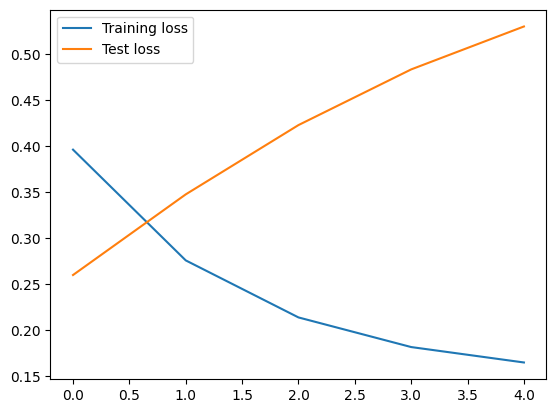

In [59]:
#! mudar num_epochs
y_train_pred, y_test_pred, hist = train_model(model=model, num_epochs=5, x_train=x_train, x_test=x_test, loss_fn=loss_fn, optimizer=optimizer)

In [60]:
def model_performance(y_train_pred, y_test_pred):
  # aplique a transformação reversa para os dados voltarem à sua escala original
  # seu código aqui

  # calcule o RSME para os conjuntos de treino e teste
  trainScore = np.sqrt(mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy()))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = np.sqrt(mean_squared_error(y_test.detach().numpy(), y_test_pred.detach().numpy()))
  print('Test Score: %.2f RMSE' % (testScore))

  # Plot dos resultados
  figure, axes = plt.subplots(figsize=(15, 6))
  axes.xaxis_date()

  axes.plot(df_aapl[len(df_aapl)-len(y_test):].index, y_test.detach().numpy(), color = 'red', label = 'Real Apple Stock Price')
  axes.plot(df_aapl[len(df_aapl)-len(y_test):].index, y_test_pred.detach().numpy(), color = 'blue', label = 'Predicted Apple Stock Price')
  plt.title('Apple Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Apple Stock Price')
  plt.legend()
  plt.show()

Train Score: 0.41 RMSE
Test Score: 0.73 RMSE


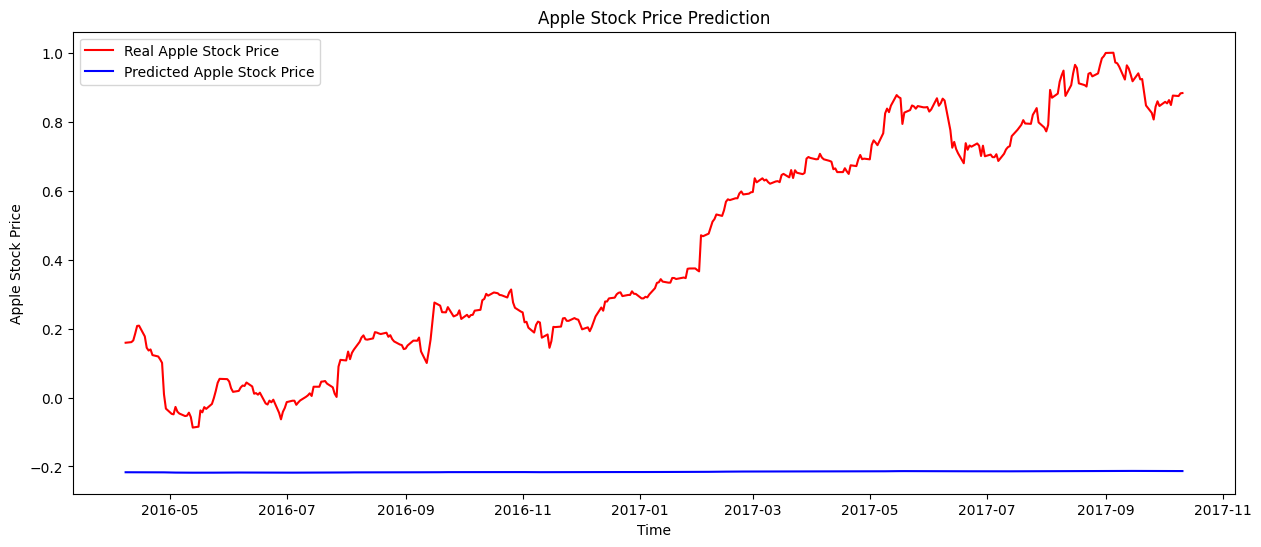

In [61]:
# execute essa célula
model_performance(y_train_pred, y_test_pred)

Agora crie uma nova rede LSTM. Você pode alterar a arquitetura original, configurar os parâmetros, defininir novas funções de custo e otimização etc. Deixe os resultados executados nas células abaixo e utilize as funções de treino e avaliação dos modelos definidas acima.

### LSTM Otimizada (Felipe e Diego)

#### Mudanças 

**Mudança de otimizador (SGD -> Adam)**

> optimizer = torch.optim.Adam(model.parameters(), lr=lr)

O otimizador Adam...

**Manter sem dropout**
> dropout=0.0

A príncio, com algumas mudanças na rede, chegamos no problema de Overfitting claro, onde o modelo não consegue generalizar bem. Então, para tentar resolver esse problema, adicionamos o Dropout, que é uma técnica de regularização que consiste em desligar aleatoriamente algumas unidades de uma camada durante o treinamento. Isso ajuda a evitar o overfitting, pois o modelo não pode depender de uma única unidade para fazer suas previsões. Porém, empiricamente não obtivemos bons resultados com o Dropout, no geral ele não alterava significantemente o erro (principalmente depois que achamos um learning rate adequado para melhorar o overfitting) e deixa a função de predição final com um cara meio *ruidosa*, devido ao dropout ser aplicado a cada passo da LSTM. Então, optamos por não utilizar o Dropout.

**Tuning do Learning Rate**

> lr = 1e-2

A partir de um processo iterativo, tunamos o learning rate até chegar em 1e-2, que foi o que melhor convergiu para a resposta querida. O primeiro passo foi diminuir significativamente o learning rate, optamos por 3e-4, depois, fomos aumentando devagar até ver qual solução melhor diminuia o erro RSME. Ao chegarmos no 1e-2 percebmos que a loss encontrava um mínimo local (muito bom) e se aumentavamos esse learning rate, o resultado era pior, por isso optamos por esse learning rate.

Um processo curioso que percebemos, é que para um learning rate um pouco maior, para o nosso caso foi de 3e-2, a rede simplesmente aprendia que a média dos valores temporais era a melhor solução para diminuir o erro (mínimo local), e a função de predição saia de uma hora para outra desse formato visto no output no fim do código e ia para algo como uma linha reta direto no valor da média dos valores temporais. Isso é um problema, pois a rede não está aprendendo nada, e o erro não diminui. Então, percebmos o quão importante é que o learning rate seja adequado para que a rede aprenda e não fique presa em um mínimo local.

In [62]:
class LSTM_optim(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_optim, self).__init__()
        self.hidden_dim = hidden_dim                                             # dimensões ocultas
        self.num_layers = num_layers                                             # número de camadas ocultas
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,                                    # batch_first=True faz com que os tensores tenham shape = (batch_dim, seq_dim, feature_dim)
                            bidirectional=False,                                 # bidirecional=False faz com que o LSTM seja unidirecional
                            dropout=0.0                                         # dropout=0.0 desativa o dropout
                            )
        #self.dropout = nn.Dropout(0.001)                                        # dropout para evitar overfitting
        self.fc = nn.Linear(hidden_dim, output_dim)                              # camada Fully Connected

    def forward(self, x):
        # inicialização com zeros

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Precisamos fazer o detach, já que realizamos o backpropagation through time (BPTT) truncado.
        # Se não fizermos isso, o backpropagation vai até o início da série
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        #out = self.dropout(out)
        
        # Só precisamos ficar com o hidden state do último passo:
        out = self.fc(out[:, -1, :])

        return out

In [63]:
# Parametros

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
lr = 1e-2 #? original: 0.1
num_epochs = 50

In [64]:
# Instancia o modelo otimizado
model = LSTM_optim(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model

LSTM_optim(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [65]:
# Define função de perda
loss_fn = torch.nn.MSELoss()

# Define otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #? original: SGD

Epoch  10 MSE:  0.015655972063541412
Epoch  20 MSE:  0.006786006037145853
Epoch  30 MSE:  0.0017614254029467702
Epoch  40 MSE:  0.0016536235343664885


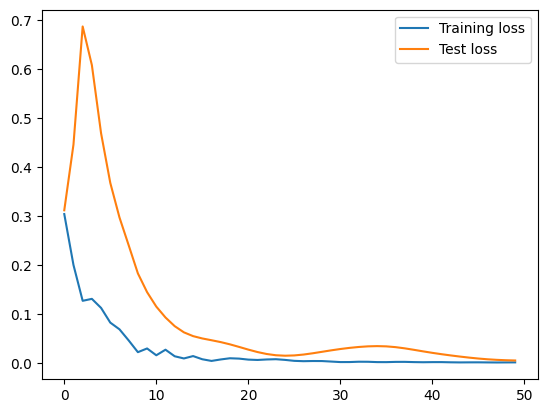

Train Score: 0.03 RMSE
Test Score: 0.07 RMSE


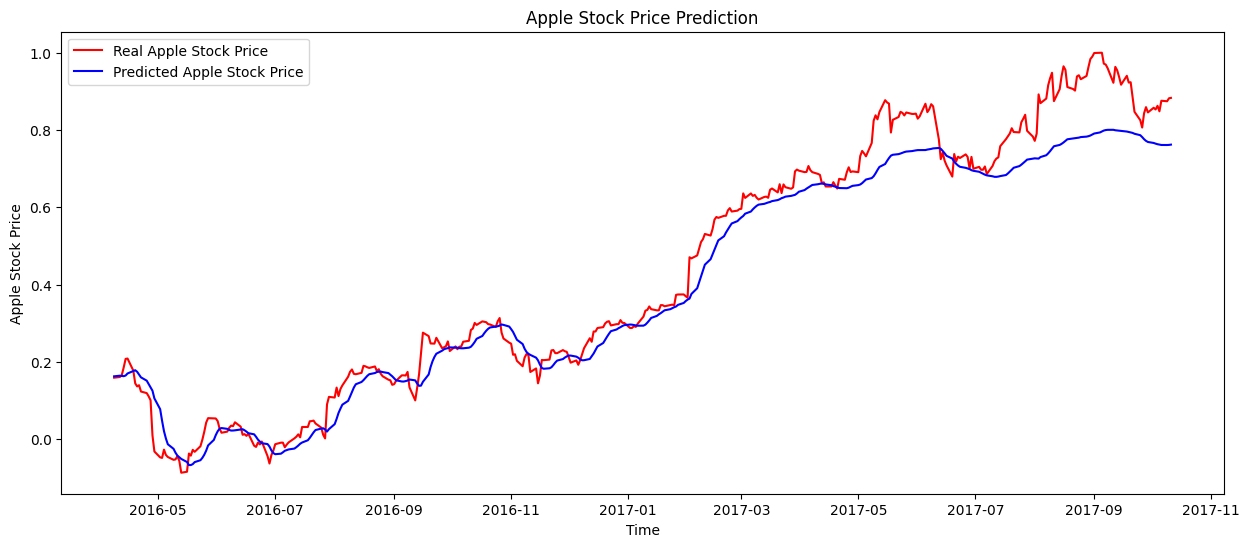

In [66]:
# treinamento
y_train_pred, y_test_pred, hist = train_model(model=model, num_epochs=num_epochs, x_train=x_train, x_test=x_test, loss_fn=loss_fn, optimizer=optimizer)
# avaliacao
model_performance(y_train_pred, y_test_pred)